# **Abstract**

This notebook presents a comprehensive analysis aimed at understanding the causal effect of being a "superhost" on the listing price within a dataset derived from Airbnb listings. The analysis is structured around the use of DoWhy, a Python library specifically designed for causal inference, enabling the exploration of cause-and-effect relationships within the data. Here's a detailed explanation of the process and findings:

# **What you'll learn-and how you can apply it**



1.   Understand how to reason causally and why it is necessary for modern data science.

1.   Use the doWhy library to build, estimate, and evaluate causal models.
2.   Learn how to practically apply causal inference to real-world data science problems.




# **Dataset Overview**

The dataset includes various attributes related to Airbnb listings, such as host_is_superhost, price, room_type, accommodates, review_scores_location, review_scores_rating, and more. It represents a mix of categorical and numerical features, with churn indicating whether a listing is active or not. The primary goal is to explore the causal impact of the host_is_superhost attribute on the price of a listing.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df = pd.read_csv('/content/churn.csv', index_col=0)
df.head()

,host_is_superhost,price,room_type,accommodates,review_scores_cleanliness,review_scores_location,review_scores_rating,host_identity_verified,host_response_time,host_response_rate,host_has_profile_pic,availability_365,calculated_host_listings_count,calendar_updated,minimum_nights,number_of_reviews,reviews_per_month,neighbourhood,churn,days_since_last_review
19444,f,200.0,Entire home/apt,3,10.0,10.0,99.0,f,a few days or more,0.0,f,243.0,1.0,4 months ago,7,4,0.0,Williamsburg,True,850.0
1520,f,450.0,Entire home/apt,4,10.0,10.0,94.0,f,a few days or more,0.0,f,208.0,1.0,2 weeks ago,3,7,0.0,Tribeca,True,505.0
1517,f,28.0,Shared room,1,0.0,0.0,0.0,f,a few days or more,0.0,f,364.0,1.0,6 weeks ago,1,0,0.0,Soundview,True,3650.0
21691,f,48.0,Private room,2,8.0,6.0,80.0,f,a few days or more,0.0,f,143.0,1.0,4 months ago,1,1,0.0,Harlem,True,612.0
21706,f,160.0,Private room,2,0.0,0.0,0.0,f,a few days or more,0.0,f,365.0,1.0,2 months ago,1,0,0.0,Tribeca,True,3650.0


# **1. Data Preparation**
Initial Data Loading: The dataset churn.csv is loaded into a Pandas DataFrame. The first column is set as the index.

Data Cleaning: Columns deemed irrelevant or redundant, such as calendar_updated, review_scores_cleanliness, and minimum_nights, are dropped to streamline the analysis.

Outlier and Irrelevant Data Filtering: The dataset is filtered to remove listings with unusually high prices (above the 99th percentile) and those with less than one review per month to focus on more common and actively reviewed listings.

Neighborhood Filtering: Only neighborhoods with at least 25 listings are retained to ensure that the analysis is concentrated on areas with sufficient data.

In [4]:
drop_columns = ['calendar_updated', 'review_scores_cleanliness', 'minimum_nights']
df.drop(drop_columns, axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77201 entries, 19444 to 0
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_is_superhost               77201 non-null  object 
 1   price                           77201 non-null  float64
 2   room_type                       77201 non-null  object 
 3   accommodates                    77201 non-null  int64  
 4   review_scores_location          77201 non-null  float64
 5   review_scores_rating            77201 non-null  float64
 6   host_identity_verified          77201 non-null  object 
 7   host_response_time              77201 non-null  object 
 8   host_response_rate              77201 non-null  float64
 9   host_has_profile_pic            77201 non-null  object 
 10  availability_365                77201 non-null  float64
 11  calculated_host_listings_count  77201 non-null  float64
 12  number_of_reviews               

In [5]:
# filter outliers with unusually high prices and listings without reviews
df_robust = df[(df.price < df.price.quantile(.99)) & (df.reviews_per_month > 1)].drop(drop_columns, axis=1)
df_robust

,host_is_superhost,price,room_type,accommodates,review_scores_location,review_scores_rating,host_identity_verified,host_response_time,host_response_rate,host_has_profile_pic,availability_365,calculated_host_listings_count,number_of_reviews,reviews_per_month,neighbourhood,churn,days_since_last_review
22815,t,79.0,Private room,1,10.0,98.0,f,within a day,100.0,f,181.0,2.0,99,1.50,Upper West Side,True,503.0
22817,f,210.0,Entire home/apt,3,10.0,92.0,f,within a few hours,89.0,f,365.0,1.0,15,1.10,Upper West Side,True,517.0
24200,f,100.0,Entire home/apt,2,9.0,96.0,f,within an hour,100.0,f,0.0,1.0,7,2.80,Washington Heights,True,429.0
23811,f,200.0,Entire home/apt,6,10.0,100.0,f,within a day,70.0,f,79.0,1.0,15,2.00,Upper West Side,True,429.0
23421,f,180.0,Entire home/apt,2,10.0,100.0,f,within a few hours,100.0,f,0.0,1.0,6,1.20,Upper West Side,True,438.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21715,f,220.0,Entire home/apt,5,10.0,87.0,f,within an hour,100.0,t,268.0,2.0,6,4.29,Midtown East,False,7.0
21719,t,349.0,Entire home/apt,12,10.0,95.0,t,within a few hours,100.0,t,351.0,1.0,4,1.67,NaN,False,34.0
21723,f,59.0,Private room,1,10.0,80.0,t,within an hour,100.0,t,202.0,1.0,41,1.50,Midtown East,False,9.0
21712,f,235.0,Entire home/apt,2,9.0,90.0,f,within a few hours,90.0,t,104.0,1.0,4,2.45,Midtown,False,9.0


In [6]:
# filter neighborhoods with at leastt 10 listings
neighborhood_ind = df_robust.neighbourhood.value_counts()[df_robust.neighbourhood.value_counts() > 25]

In [7]:
neighborhood_ind.index

Index(['Williamsburg', 'Hell's Kitchen', 'Bedford-Stuyvesant',
       'Upper East Side', 'Upper West Side', 'East Village', 'Harlem',
       'Bushwick', 'Lower East Side', 'Chelsea', 'East Harlem',
       'Crown Heights', 'Alphabet City', 'Astoria', 'West Village',
       'Washington Heights', 'Hamilton Heights', 'Greenpoint', 'Midtown East',
       'Park Slope', 'Clinton Hill', 'Midtown', 'Greenwich Village',
       'Kips Bay', 'Flatbush', 'Financial District', 'Chinatown', 'Soho',
       'Fort Greene', 'Nolita', 'Gramercy Park', 'Lefferts Garden',
       'Flatiron District', 'Murray Hill', 'Prospect Heights', 'Boerum Hill',
       'Sunnyside', 'Times Square/Theatre District', 'Long Island City',
       'Ridgewood', 'Morningside Heights', 'Sunset Park', 'Ditmars / Steinway',
       'Jamaica', 'Carroll Gardens', 'Flushing', 'Tribeca', 'Jackson Heights',
       'Brooklyn Heights', 'Downtown Brooklyn', 'Meatpacking District',
       'Elmhurst', 'East Flatbush', 'Inwood', 'East New York',

# **2: Exploratory Data Analysis (EDA)**

In [8]:
df_sample = df_robust[df_robust.neighbourhood.isin(neighborhood_ind.index)]
df_sample

,host_is_superhost,price,room_type,accommodates,review_scores_location,review_scores_rating,host_identity_verified,host_response_time,host_response_rate,host_has_profile_pic,availability_365,calculated_host_listings_count,number_of_reviews,reviews_per_month,neighbourhood,churn,days_since_last_review
22815,t,79.0,Private room,1,10.0,98.0,f,within a day,100.0,f,181.0,2.0,99,1.50,Upper West Side,True,503.0
22817,f,210.0,Entire home/apt,3,10.0,92.0,f,within a few hours,89.0,f,365.0,1.0,15,1.10,Upper West Side,True,517.0
24200,f,100.0,Entire home/apt,2,9.0,96.0,f,within an hour,100.0,f,0.0,1.0,7,2.80,Washington Heights,True,429.0
23811,f,200.0,Entire home/apt,6,10.0,100.0,f,within a day,70.0,f,79.0,1.0,15,2.00,Upper West Side,True,429.0
23421,f,180.0,Entire home/apt,2,10.0,100.0,f,within a few hours,100.0,f,0.0,1.0,6,1.20,Upper West Side,True,438.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21727,f,150.0,Entire home/apt,6,10.0,83.0,t,within an hour,100.0,t,256.0,1.0,82,2.58,Midtown East,False,20.0
21711,f,360.0,Entire home/apt,4,10.0,97.0,t,within an hour,91.0,t,308.0,1.0,100,1.76,Midtown,False,23.0
21715,f,220.0,Entire home/apt,5,10.0,87.0,f,within an hour,100.0,t,268.0,2.0,6,4.29,Midtown East,False,7.0
21723,f,59.0,Private room,1,10.0,80.0,t,within an hour,100.0,t,202.0,1.0,41,1.50,Midtown East,False,9.0


In [38]:
df_sample.info

<bound method DataFrame.info of       host_is_superhost  price        room_type  accommodates  \
22815                 t   79.0     Private room             1   
22817                 f  210.0  Entire home/apt             3   
24200                 f  100.0  Entire home/apt             2   
23811                 f  200.0  Entire home/apt             6   
23421                 f  180.0  Entire home/apt             2   
...                 ...    ...              ...           ...   
21727                 f  150.0  Entire home/apt             6   
21711                 f  360.0  Entire home/apt             4   
21715                 f  220.0  Entire home/apt             5   
21723                 f   59.0     Private room             1   
21712                 f  235.0  Entire home/apt             2   

       review_scores_location  review_scores_rating host_identity_verified  \
22815                    10.0                  98.0                      f   
22817                    10.0                  92.0                      f   
24200                     9.0                  96.0                      f   
23811                    10.0                 100.0                      f   
23421                    10.0                 100.0                      f   
...                       ...                   ...                    ...   
21727                    10.0                  83.0                      t   
21711                    10.0                  97.0                      t   
21715                    10.0                  87.0                      f   
21723                    10.0                  80.0                      t   
21712                     9.0                  90.0                      f   

       host_response_time  host_response_rate host_has_profile_pic  \
22815        within a day               100.0                    f   
22817  within a few hours                89.0                    f   
24200      within an hour               100.0                    f   
23811        within a day                70.0                    f   
23421  within a few hours               100.0                    f   
...                   ...                 ...                  ...   
21727      within an hour               100.0                    t   
21711      within an hour                91.0                    t   
21715      within an hour               100.0                    t   
21723      within an hour               100.0                    t   
21712  within a few hours                90.0                    t   

       availability_365  calculated_host_listings_count  number_of_reviews  \
22815             181.0                             2.0                 99   
22817             365.0                             1.0                 15   
24200               0.0                             1.0                  7   
23811              79.0                             1.0                 15   
23421               0.0                             1.0                  6   
...                 ...                             ...                ...   
21727             256.0                             1.0                 82   
21711             308.0                             1.0                100   
21715             268.0                             2.0                  6   
21723             202.0                             1.0                 41   
21712             104.0                             1.0                  4   

       reviews_per_month       neighbourhood  churn  days_since_last_review  
22815               1.50     Upper West Side   True                   503.0  
22817               1.10     Upper West Side   True                   517.0  
24200               2.80  Washington Heights   True                   429.0  
23811               2.00     Upper West Side   True                   429.0  
23421               1.20     Upper West Side   True                   438.0  
... 

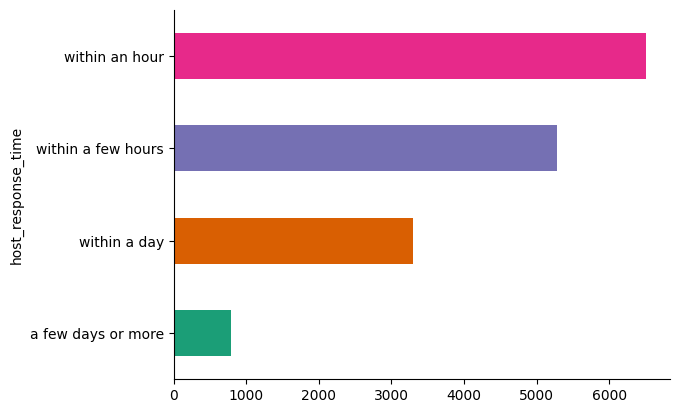

In [9]:
# @title host_response_time

from matplotlib import pyplot as plt
import seaborn as sns
df_sample.groupby('host_response_time').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

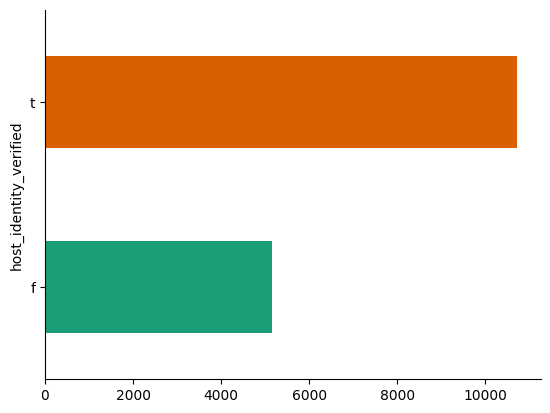

In [10]:
# @title host_identity_verified

from matplotlib import pyplot as plt
import seaborn as sns
df_sample.groupby('host_identity_verified').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

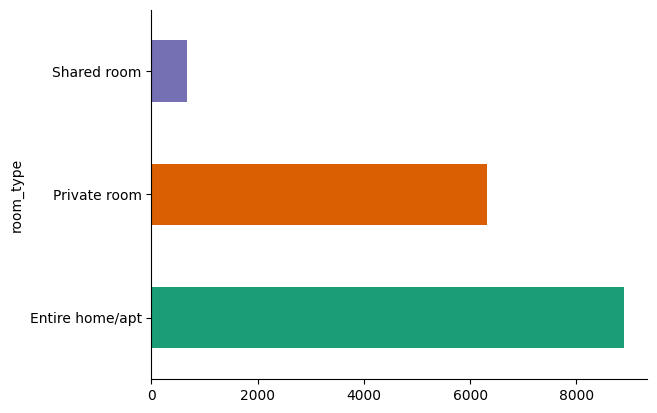

In [11]:
# @title room_type

from matplotlib import pyplot as plt
import seaborn as sns
df_sample.groupby('room_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

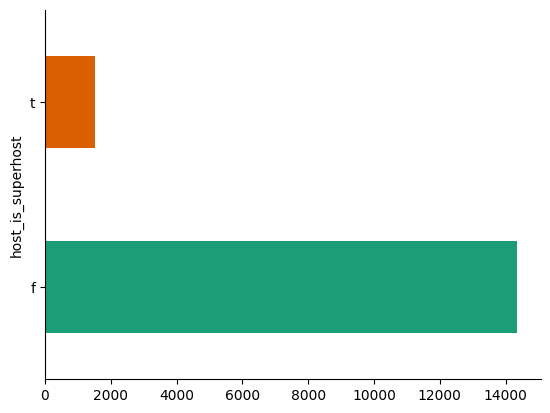

In [12]:
# @title host_is_superhost

from matplotlib import pyplot as plt
import seaborn as sns
df_sample.groupby('host_is_superhost').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

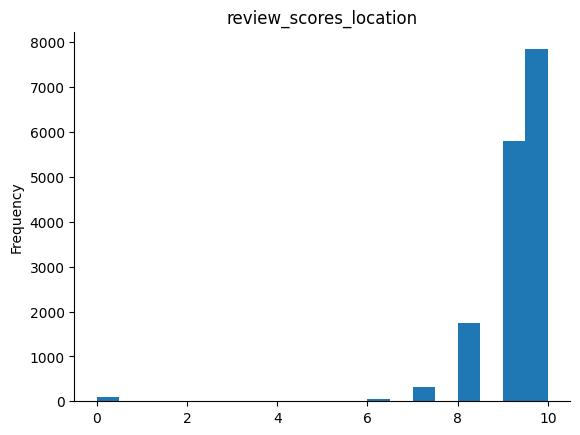

In [13]:
# @title review_scores_location

from matplotlib import pyplot as plt
df_sample['review_scores_location'].plot(kind='hist', bins=20, title='review_scores_location')
plt.gca().spines[['top', 'right',]].set_visible(False)

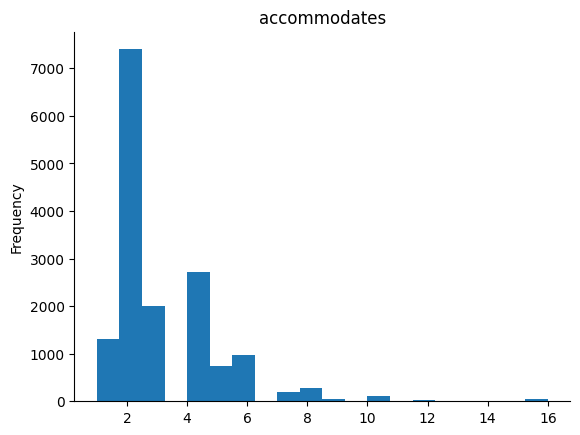

In [14]:
# @title accommodates

from matplotlib import pyplot as plt
df_sample['accommodates'].plot(kind='hist', bins=20, title='accommodates')
plt.gca().spines[['top', 'right',]].set_visible(False)

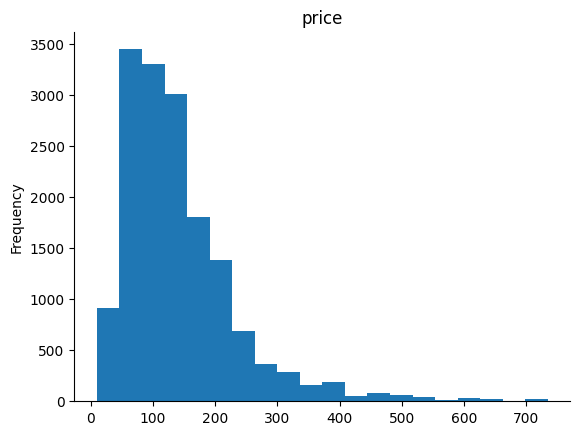

In [15]:
# @title price

from matplotlib import pyplot as plt
df_sample['price'].plot(kind='hist', bins=20, title='price')
plt.gca().spines[['top', 'right',]].set_visible(False)

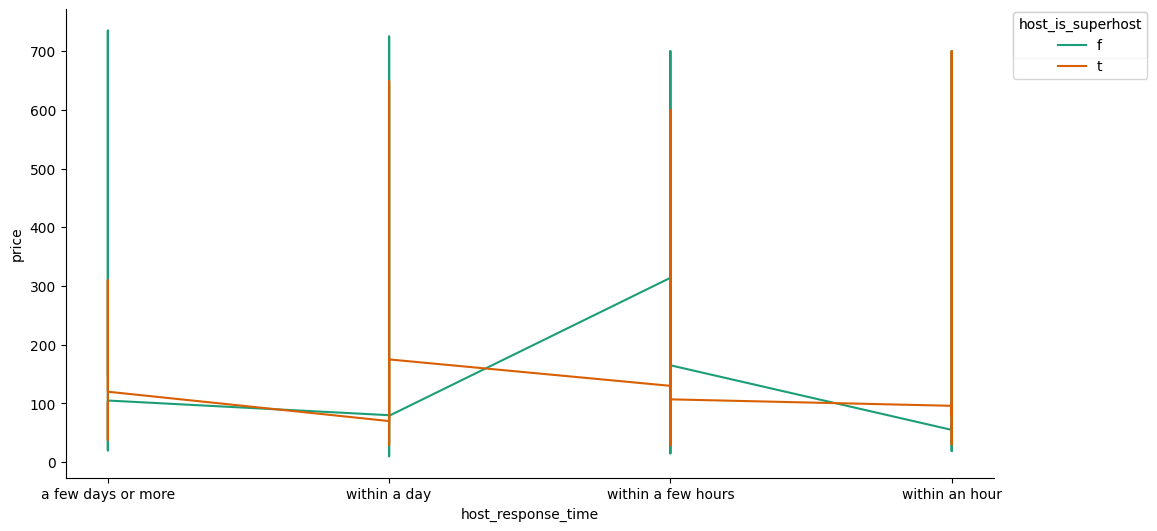

In [16]:
# @title host_response_time vs price

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['host_response_time']
  ys = series['price']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_sample.sort_values('host_response_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('host_is_superhost')):
  _plot_series(series, series_name, i)
  fig.legend(title='host_is_superhost', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('host_response_time')
_ = plt.ylabel('price')

In [18]:
cor=df_sample.corr()
cor

,price,accommodates,review_scores_location,review_scores_rating,host_response_rate,availability_365,calculated_host_listings_count,number_of_reviews,reviews_per_month,churn,days_since_last_review
price,1.000000,0.531858,0.184219,0.068662,0.003928,0.053212,-0.150241,-0.016340,-0.056087,0.071592,0.043644
accommodates,0.531858,1.000000,-0.066920,-0.079421,0.050685,0.092481,0.047068,0.016198,0.030123,0.008468,-0.012861
review_scores_location,0.184219,-0.066920,1.000000,0.670468,0.043586,-0.101734,-0.121352,0.008041,-0.007762,-0.046526,-0.051390
review_scores_rating,0.068662,-0.079421,0.670468,1.000000,0.089846,-0.112047,-0.147862,0.042767,-0.020539,-0.124145,-0.102509
host_response_rate,0.003928,0.050685,0.043586,0.089846,1.000000,-0.019780,0.105278,0.086111,0.180173,-0.162835,-0.208425
availability_365,0.053212,0.092481,-0.101734,-0.112047,-0.019780,1.000000,0.150568,0.107545,-0.032877,0.056999,0.053499
calculated_host_listings_count,-0.150241,0.047068,-0.121352,-0.147862,0.105278,0.150568,1.000000,-0.016278,0.081551,0.010646,0.040069
number_of_reviews,-0.016340,0.016198,0.008041,0.042767,0.086111,0.107545,-0.016278,1.000000,0.240824,-0.208308,-0.169266
reviews_per_month,-0.056087,0.030123,-0.007762,-0.020539,0.180173,-0.032877,0.081551,0.240824,1.000000,-0.053228,-0.128557
churn,0.071592,0.008468,-0.046526,-0.124145,-0.162835,0.056999,0.010646,-0.208308,-0.053228,1.000000,0.766564


<Axes: >

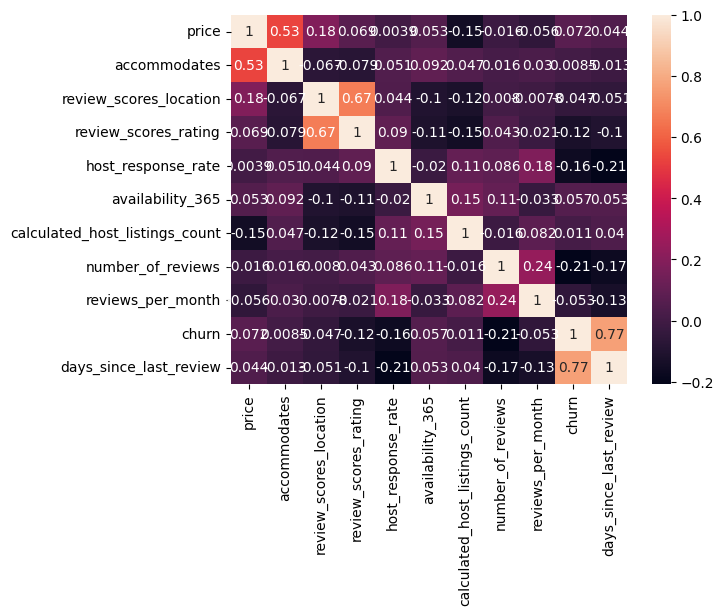

In [17]:
sns.heatmap(df_sample.corr(), annot =True)

In [19]:
df_sample.groupby('neighbourhood').reviews_per_month.mean().sort_values()[:-30:-1]

neighbourhood
Jamaica                          2.771143
Midtown                          2.722911
Hell's Kitchen                   2.646255
Corona                           2.614667
Flushing                         2.558000
Times Square/Theatre District    2.548295
East Village                     2.492773
Mott Haven                       2.488148
Bedford-Stuyvesant               2.483807
Ditmars / Steinway               2.478356
Gowanus                          2.441795
Bushwick                         2.437002
Astoria                          2.435036
East Harlem                      2.405789
Union Square                     2.405319
East Flatbush                    2.365208
Kips Bay                         2.364806
Ridgewood                        2.352169
Nolita                           2.339801
Williamsburg                     2.332197
Chelsea                          2.320615
Hamilton Heights                 2.318769
Washington Heights               2.303174
Soho                

In [20]:
df_sample.groupby('neighbourhood').price.mean().sort_values()[:-30:-1]

neighbourhood
Tribeca                          296.089286
Soho                             262.210526
Flatiron District                232.636364
Union Square                     225.021277
West Village                     215.951220
Midtown                          209.544304
Meatpacking District             203.220000
Times Square/Theatre District    202.602273
Greenwich Village                197.130435
Battery Park City                196.896552
Chelsea                          196.640385
Nolita                           191.741722
Financial District               191.158470
Gramercy Park                    186.510204
Murray Hill                      183.650943
Hell's Kitchen                   182.109577
Midtown East                     181.972441
Kips Bay                         178.533981
Little Italy                     177.650000
East Village                     171.540832
Carroll Gardens                  167.046154
Upper West Side                  163.148387
Brooklyn Heights  

In [21]:
df_sample.groupby('churn')['price',
                           'reviews_per_month',
                           'number_of_reviews',
                           'host_response_time',
                           'host_response_rate',
                           'calculated_host_listings_count',
                           'days_since_last_review',
                           'review_scores_rating'].mean()

,price,reviews_per_month,number_of_reviews,host_response_rate,calculated_host_listings_count,days_since_last_review,review_scores_rating
churn,,,,,,,
False,135.84452,2.380221,36.016897,91.151960,2.119221,30.341352,92.089181
True,149.24813,2.248421,22.184329,84.518025,2.181200,237.820705,89.591756


# **3. Causal Inference with DoWhy**

**Model Setup:** The DoWhy library is used to set up a causal model to explore the effect of being a superhost (host_is_superhost) on the listing price (price). Key variables such as room type, accommodates, and review scores are included as common causes (confounders) that might affect both the treatment (being a superhost) and the outcome (price).

**Causal Estimation:** The causal effect is estimated using propensity score matching, a method that attempts to balance treatment and control groups based on the observed covariates to mimic a randomized controlled trial.

**Initial Causal Estimate:** The initial estimate suggests that being a superhost decreases the listing price by approximately $13.68, which is counterintuitive.

**Refutation Tests:** Several refutation tests are performed to check the robustness of the causal estimate. These tests include adding a random common cause, using a placebo treatment, and using a subset of data. The varied results from these tests indicate potential sensitivities in the causal estimate.

In [22]:
!pip install dowhy
import dowhy
from dowhy import CausalModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 21.4 MB/s eta 0:00:00


In [23]:
df_sample.room_type.unique()


array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [24]:
df_why = df_sample.copy()


In [25]:
df_why['host_is_superhost'] = df_sample.host_is_superhost == 't'


In [26]:
model=CausalModel(
        data=df_why,
        treatment='host_is_superhost',
        outcome='price',
        common_causes=['room_type',
                        'accommodates',
                        'review_scores_rating'])

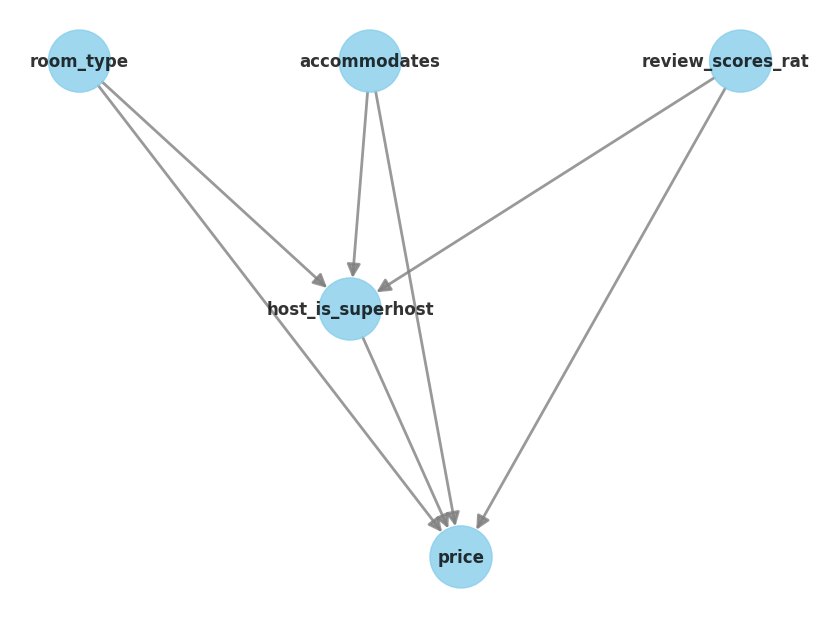

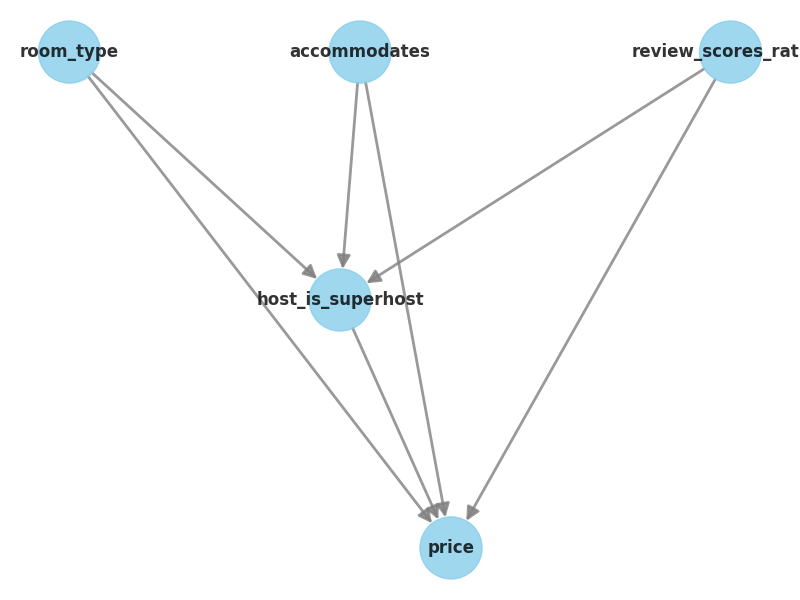

In [27]:
from IPython.display import Image, display

model.view_model(layout="dot")
display(Image(filename="causal_model.png"))

In [28]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [29]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")

In [30]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                               
───────────────────(E[price|accommodates,room_type,review_scores_rating])
d[hostᵢₛ ₛᵤₚₑᵣₕₒₛₜ]                                                      
Estimand assumption 1, Unconfoundedness: If U→{host_is_superhost} and U→price then P(price|host_is_superhost,accommodates,room_type,review_scores_rating,U) = P(price|host_is_superhost,accommodates,room_type,review_scores_rating)

## Realized estimand
b: price~host_is_superhost+accommodates+room_type+review_scores_rating
Target units: ate

## Estimate
Mean value: 14.14987714987715



In [31]:
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="random_common_cause")
print(refute_results)

Refute: Add a random common cause
Estimated effect:14.14987714987715
New effect:14.149877149877147
p value:1.0



In [32]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:14.14987714987715
New effect:1.013230643230643
p value:0.8799999999999999



In [33]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:14.14987714987715
New effect:8.064097018059638
p value:0.22



In [34]:
model=CausalModel(
        data=df_why,
        treatment='host_is_superhost',
        outcome='price',
        common_causes=['neighbourhood',
                        'room_type',
                        'accommodates',
                        'review_scores_rating'])

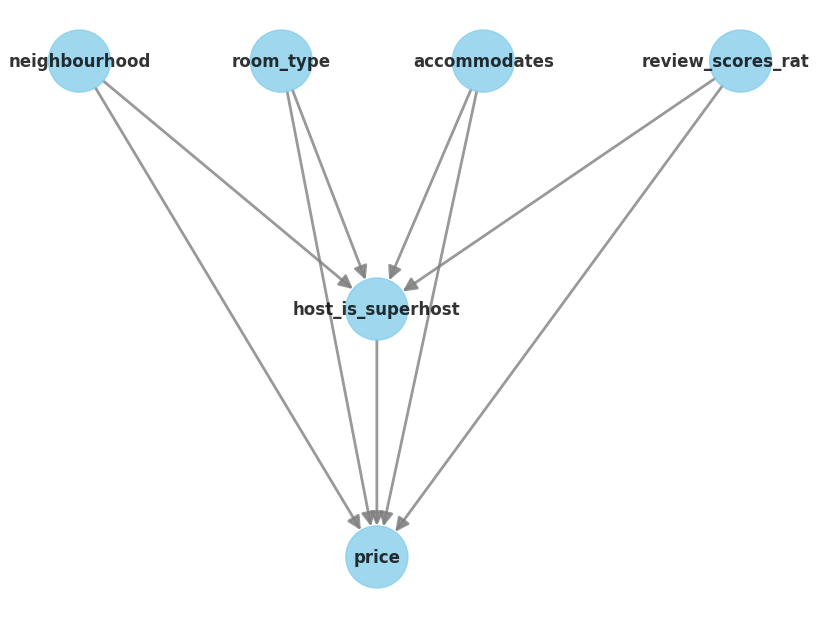

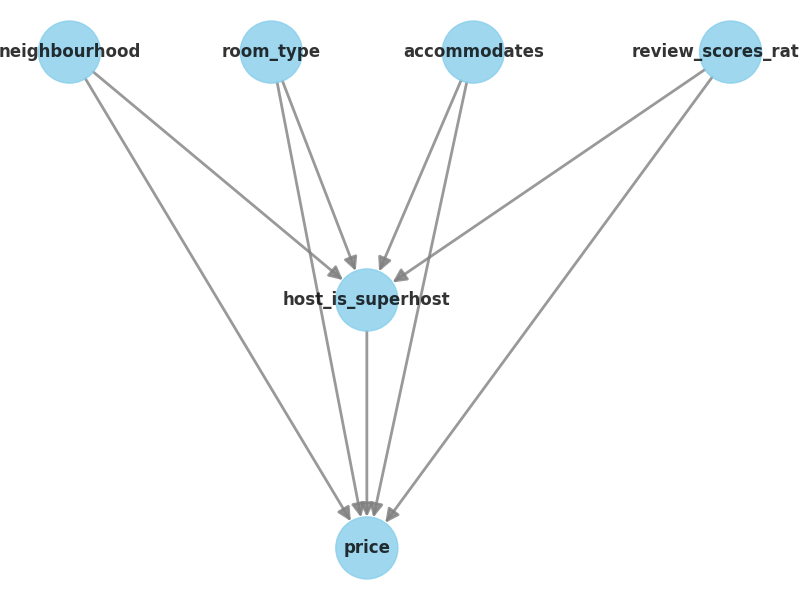

In [35]:
from IPython.display import Image, display

model.view_model(layout="dot")
display(Image(filename="causal_model.png"))

In [36]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching")
print(f"New causal Estimate with neighbourhood is:  {estimate.value}")

New causal Estimate with neighbourhood is:  14.14987714987715


In [37]:
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="random_common_cause")
print(refute_results)

res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Add a random common cause
Estimated effect:14.14987714987715
New effect:14.149877149877147
p value:1.0

Refute: Use a Placebo Treatment
Estimated effect:14.14987714987715
New effect:-0.007867447867447775
p value:0.98

Refute: Use a subset of data
Estimated effect:14.14987714987715
New effect:8.537581548369031
p value:0.32



# **Interpretation with Numerical Insights**


**Causal Estimate (Initial Finding):**

Initial Estimate: The causal model estimated that being a superhost is associated with an increase in listing price by approximately $14.15. This positive numerical value directly quantifies the advantage in pricing that superhosts have over non-superhosts, suggesting that the market values the superhost status.

**Refutation Tests:**
Add a Random Common Cause: This test did not significantly alter the estimated effect, which remained around $14.15. The p-value being 1.0 suggests that this added variable did not provide new information that could have swayed the causal relationship, reinforcing the initial findings' credibility.


**Placebo Treatment:** The effect size significantly dropped to near zero (-$0.0078) under the placebo treatment, with a p-value close to 1 (0.98), indicating that when the treatment (superhost status) is randomized, it no longer affects the price, as expected in a causal relationship.


**Subset of Data:** Reducing the dataset to 90% of its original size resulted in a new effect size of $8.54, with a p-value of 0.32. While this effect is smaller than the initial estimate, it still indicates a positive impact, albeit at a reduced magnitude. This variation underscores the robustness of the initial finding, even though the magnitude of the effect can fluctuate based on the dataset sampled.


# **Conclusion:**

The causal analysis, grounded in both the initial estimate and various refutation tests, consistently points to a positive causal impact of being a superhost on the listing price on Airbnb, quantified at an approximate increase of $14.15 in the initial model. This numerical insight is significant for several reasons:

**Economic Implication:** For Airbnb hosts, the superhost status not only serves as a badge of trust and quality but also carries a tangible financial benefit, enabling them to charge more for their listings. This premium, quantified in our analysis, underscores the economic value of maintaining high service standards on the platform.

**Value of Certification: **From a guest's perspective, the price premium associated with superhost listings could be viewed as the cost of a higher probability of a positive experience. This adds a quantitative perspective to the decision-making process for guests considering superhost listings.

**Policy and Strategy:** For Airbnb as a platform, understanding the quantitative impact of superhost status on listing prices can inform strategies around encouraging host quality and differentiation. It highlights the importance of such recognition programs in shaping user behavior and market dynamics.

**Robustness of Findings:** The refutation tests, particularly the use of a placebo treatment and data subsets, provide a critical check on the reliability of the causal estimate. The slight variations in effect size across different tests underscore the importance of considering sample and methodological robustness in causal inference studies.

In essence, this analysis provides a robust quantitative foundation to the understanding that achieving and maintaining superhost status on Airbnb not only signifies a mark of quality but also translates into a measurable economic benefit. This insight has practical implications for hosts aiming to optimize their earnings, for guests evaluating potential listings, and for the platform in designing mechanisms to promote quality and trustworthiness.

# **References**

1.   https://sites.google.com/view/sshimizu06/lingam/lingampapers/basic-linear-models
2.   https://www.microsoft.com/en-us/research/group/causal-inference/
3.  https://www.sciencedirect.com/topics/social-sciences/causal-inference#:~:text=Causal%20inference%20refers%20to%20an,causal%20conclusions%20based%20on%20data.




MIT License

Copyright (c) 2024 Vivek Basavanth Hanagoji

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.